
<b>Mohammad Ariful Islam</b>  
<b>B00841409</b> 

## Task 1 : Data Understanding and Preprocessing<a id='top'></a>



In [1]:
#Importing Libraries
import os
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
import category_encoders as ce
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import csv 
import copy

In [38]:
#Set Working Directory
working_directory= os.getcwd()
print(working_directory)

E:\Data processing course\assignments\a1


Dataset Link : https://www.kaggle.com/stefanoleone992/tripadvisor-european-restaurants

In [2]:
x = pd.read_csv('../a1_dataset/tripadvisor_european_restaurants.csv')

#x = x.sample(n=200000)
df = pd.DataFrame(x)
dfs = df.copy()
dft = df.copy()
df.head()

C:\Users\arifu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,...,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
0,g10001637-d10002227,Le 147,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"10 Maison Neuve, 87510 Saint-Jouvent France",45.961674,1.169131,...,2.0,0.0,0.0,0.0,0.0,4.0,4.5,4.0,NaN,NaN
1,g10001637-d14975787,Le Saint Jouvent,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"16 Place de l Eglise, 87510 Saint-Jouvent France",45.957040,1.205480,...,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,g10002858-d4586832,Au Bout du Pont,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",France,Centre-Val de Loire,Berry,Rivarennes,"2 rue des Dames, 36800 Rivarennes France",46.635895,1.386133,...,3.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,g10002986-d3510044,Le Relais de Naiade,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Lacelle,"9 avenue Porte de la Correze 19170, 19170 Lace...",45.642610,1.824460,...,1.0,0.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN
4,g10022428-d9767191,Relais Du MontSeigne,"[""Europe"", ""France"", ""Occitanie"", ""Aveyron"", ""...",France,Occitanie,Aveyron,Saint-Laurent-de-Levezou,"route du Montseigne, 12620 Saint-Laurent-de-Le...",44.208860,2.960470,...,4.0,7.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN


### Separation of continous and categorical features

In [3]:
#Continous features or conFeat
conFeat = ['open_days_per_week','latitude', 'longitude',
       'open_hours_per_week', 'working_shifts_per_week', 'avg_rating',
       'total_reviews_count', 'reviews_count_in_default_language', 'excellent', 'very_good',
       'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere']

#Categorical features or catFeat
catFeat = ['restaurant_link', 'restaurant_name', 'original_location', 'country',
       'region', 'province', 'city', 'address',
       'claimed', 'awards', 'popularity_detailed', 'popularity_generic',
       'top_tags', 'price_level', 'price_range', 'meals', 'cuisines',
       'special_diets', 'features','default_language', 'vegetarian_friendly', 'vegan_options',
       'gluten_free','original_open_hours','keywords']

### Data Quality Report Generation

In [4]:
t = len(df.index)

def getHeaders():
    
    headersList = df.columns
    return headersList, conFeat, catFeat

def processContinuous(conFeat, data):
    conHead = ['Count', 'Miss %', 'Card.', 'Min', '1st Qrt.', 'Mean', 'Median', '3rd Qrt', 'Max', 'Std. Dev.']

    conF = pd.DataFrame(index=conFeat, columns=conHead)
    conF.index.name = 'FEATURE_NAME'
    columns = data[conFeat]  
  
    count = columns.count()
    conF[conHead[0]] = count # count

#     percents = [''] * len(conFeat)
#     for col in columns:   
#         percents[conFeat.index(col)] = t/ count * 100

    percentage =((df[conFeat].isna().sum())/t)*100
    
    conF[conHead[1]] =  percentage             #Missing values
    conF[conHead[2]] = columns.nunique()       #Cardinality
    conF[conHead[3]] = columns.min()           #Minimum Value
    conF[conHead[4]] = columns.quantile(0.25)  #First Quartile
    conF[conHead[5]] = round(columns.mean(), 2)#Mean
    conF[conHead[6]] = columns.median()        #Median
    conF[conHead[7]] = columns.quantile(0.75)  #Third Quartile
    conF[conHead[8]] = columns.max()           #Max Value
    conF[conHead[9]] = round(columns.std(), 2) #Standard Deviation

    return conF

def processCategorical(catFeat, data):
    catHead = ['Count', 'Miss %', 'Card.', 'Mode', 'Mode Freq', 'Mode %', '2nd Mode', '2nd Mode Freq', '2nd Mode %']

    catF = pd.DataFrame(index=catFeat, columns=catHead)
    catF.index.name = 'FEATURE_NAME'
    columns = data[catFeat]

    #Count
    count = columns.count()
    catF[catHead[0]] = count

    #Cardinality
    catF[catHead[2]] = columns.nunique()

    #Preparing arrays for storing data
    s = len(catFeat)
    missPercents = [''] * s
    modeFreqs = [''] * s
    modes = [''] * s
    modes2 = [''] * s
    modePercents = [''] * s
    modeFreqs2 = [''] * s
    modePercents2 = [''] * s
    
    for col in columns:
        values = columns[col].value_counts()
        index = catFeat.index(col)

        try:
            NaNCount = values.loc['NaN']
            percent = (NaNCount / count[index]) * 100
            missPercents[index] = round(percent, 2)

            catF['Card.'][index] -= 1
        except Exception as e:
            missPercents[index] = 0.00

        mode = values.index[0]
        mode2 = values.index[0]
        modes[index] = mode
        modes2[index] = mode2

        # Mode Frequency
        modeCount = values.loc[mode]
        modeCount2 = values.loc[mode2]
        modeFreqs[index] = modeCount
        modeFreqs2[index] = modeCount2

        # Mode percentage %
        miss = missPercents[index]
        modePer = (modeCount / (count[index] * ((100 - miss) / 100))) * 100
        modePercents[index] = round(modePer, 2)

        modePer2 = (modeCount2 / (count[index] * ((100 - miss) / 100))) * 100
        modePercents2[index] = round(modePer2, 2)
    
    percentage =((df[catFeat].isna().sum())/t)*100
    
    catF[catHead[1]] = percentage
    catF[catHead[3]] = modes
    catF[catHead[4]] = modeFreqs
    catF[catHead[5]] = modePercents
    catF[catHead[6]] = modes2
    catF[catHead[7]] = modeFreqs2
    catF[catHead[8]] = modePercents2

    return catF

def main():
    warnings.simplefilter(action='ignore', category=Warning)

    allHead, conFeat, catFeat = getHeaders()

    data = df
    conF = processContinuous(conFeat, data)
    catF = processCategorical(catFeat, data)

    print(conF)
    print(catF)

    #WRITE TO FILES
#     conF.to_csv(r"E:\Data processing course\assignments\a1\con_dqr.csv")
#     catF.to_csv(r"E:\Data processing course\assignments\a1\cat_dqr.csv")
    

if __name__ == '__main__':
    main()

                                     Count     Miss %   Card.        Min  \
FEATURE_NAME                                                               
open_days_per_week                  593832  45.187960       7   1.000000   
latitude                           1067607   1.457453  857920  27.640310   
longitude                          1067607   1.457453  969586 -71.218094   
open_hours_per_week                 593832  45.187960    3090   0.000000   
working_shifts_per_week             593832  45.187960      15   1.000000   
avg_rating                          986761   8.919722       9   1.000000   
total_reviews_count                1031162   4.821409    3363   0.000000   
reviews_count_in_default_language   988204   8.786530    2415   1.000000   
excellent                           988204   8.786530    1708   0.000000   
very_good                           988204   8.786530     832   0.000000   
average                             988204   8.786530     458   0.000000   
poor        

###  Correlation Heat Map
Correlation Heatmap plot of the given variables

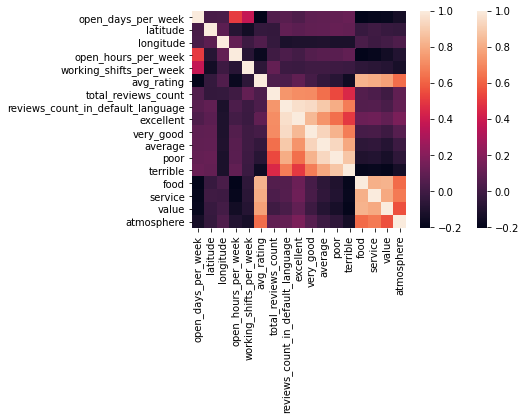

In [5]:
allHead, conFeat, catFeat = getHeaders()

condf = df[conFeat]
sns.heatmap(condf.corr())
catdf = df[catFeat]
sns.heatmap(condf.corr())

### Data Quality Issues, Plan, and Preprocessing 

The inconsistent and incomplete data fields as observed from data understanding and preprocessing are treated to improve the quality of the data. These steps will help reduce the overfitting and the right feature selection can be performed using the process flow:

Filling Missing Data -> Categorical Encoding -> Feature Selection 

### Filling Missing Data
This step is performed by replacing continous data which is missing with mean, and missing categorical data with label encoding and "unknown" label.

#### Replacing the continous data with mean

In [6]:
df['country'].astype(str)
dqr_con = pd.read_csv("con_dqr.csv") 
feature_lst_con = dqr_con[dqr_con['Miss %'] != 0.0]['FEATURE_NAME'].tolist()
feature_lst_con
for ftr in feature_lst_con:
    df[ftr].fillna(df[ftr].mean(), inplace=True)
#df['excellent'].fillna(df['excellent'].mean(), inplace=True)
ll = df[feature_lst_con].isna().sum()

print("missing values of continous features in the dataset:\n{}".format(ll))

missing values of continous features in the dataset:
open_days_per_week                   0
latitude                             0
longitude                            0
open_hours_per_week                  0
working_shifts_per_week              0
avg_rating                           0
total_reviews_count                  0
reviews_count_in_default_language    0
excellent                            0
very_good                            0
average                              0
poor                                 0
terrible                             0
food                                 0
service                              0
value                                0
atmosphere                           0
dtype: int64


#### Replacing the categorical data and applying __label encoding__ to the features with cardinality 2,3

In [7]:
dqr_cat = pd.read_csv("cat_dqr.csv") 
feature_miss_cat = dqr_cat[dqr_cat['Miss %'] != 0.0]['FEATURE_NAME'].tolist()
feature_low_cat = dqr_cat[dqr_cat['Card.'] <= 3.0 ]['FEATURE_NAME'].tolist()
ftr_miss =list(set(feature_miss_cat) - set(feature_low_cat)) + list(set(feature_low_cat) - set(feature_miss_cat))

label_encoding = {'claimed' : {'claimed' : 1, 'unclaimed':0},
                 'price_level' : {'€': 1, '€€-€€€' : 2, '€€€€':4},
                 'default_language':{'English':1,'All languages':0},
                  'vegetarian_friendly':{'Y':1,'N':0},
                  'vegan_options':{'Y':1,'N':0},
                  'gluten_free':{'Y':1,'N':0}}

df = df.replace(label_encoding)

df.dropna(inplace = True)

ftr_miss
                  
                  
for ftr in ftr_miss:
    df[ftr].fillna('Unknown', inplace=True)
    

ll = df[feature_lst_con].isna().sum()
print("missing values of continous features in the dataset:\n{}".format(ll))

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df.head(20))

missing values of continous features in the dataset:
open_days_per_week                   0
latitude                             0
longitude                            0
open_hours_per_week                  0
working_shifts_per_week              0
avg_rating                           0
total_reviews_count                  0
reviews_count_in_default_language    0
excellent                            0
very_good                            0
average                              0
poor                                 0
terrible                             0
food                                 0
service                              0
value                                0
atmosphere                           0
dtype: int64


### Categorical Encoding

Binary Encoding is a useful step for data preparation which gets applied to categorical features which is a combination of hash encoding and one-hot encoding.

In [8]:
# Applying Binary Encoder 

encoder = ce.BinaryEncoder(catFeat, return_df=True)

data_encoded = encoder.fit_transform(df)
dfx = pd.DataFrame(data_encoded)
dfx.head()



,restaurant_link_0,restaurant_link_1,restaurant_link_2,restaurant_link_3,restaurant_link_4,restaurant_link_5,restaurant_link_6,restaurant_link_7,restaurant_link_8,restaurant_link_9,...,keywords_3,keywords_4,keywords_5,keywords_6,keywords_7,keywords_8,keywords_9,keywords_10,keywords_11,keywords_12
918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
18106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


### Question and Answer (QnA)

__Question: Finding average ratio of restaurants which are in France and Italy, and open atleast 4 days a week__

In [9]:
#Answer

#dft['country'] = dft['country'].astype(str)
dft.head()
df_res = pd.DataFrame()
df_res = dft['avg_rating'][(dft.country.isin(['France','Italy'])) & (dft.open_days_per_week >= 4)]
df_res


5         4.5
6         4.5
7         4.5
8         5.0
9         4.5
         ... 
874794    4.0
874795    4.5
874797    4.5
874802    4.0
874803    4.0
Name: avg_rating, Length: 198736, dtype: float64

__Question: Based on the data quality report, which attributes will be able to decide the rating of a restaurant? Explain why you think selected attribute is important?__

__Answer__

The attributes location, price range, and meals can help decide the restaurant rating, i.e. average rating. It is important because this attribute value defines the sum total of responses received from the users as customer feedback and the ratings they gave when they visited a particular restaurant and have a high coorelation.

## Task 2 : Spatial Data

__European countries with a heatmap based on average working hours per day in a restaurant__

__Mark the "Restaurant" (lat, long - 50.6381, 3.02347) on the city map__

__Plot all the restaurant in the radius of 50 km of the restaurant marked in previous section__

In [10]:
#from pyrosm import OSM, get_data
#import geopandas as gpd

#European Map Data
#european_osm = OSM(get_data('europe'), bounding_box=[-29.011384,36.260820,49.562835,71.166017])

# Get all boundaries as a GeoDataFrame
#euro_boundaries = european_osm.get_boundaries()

#Calculation of average working hours per day, i.e. avg_work_hours_per_day
#Dataframe with (avg_work_hours_per_day, latitude, longitude, original_location) where original_location is "Europe"

#euro_avg= df[ ['open_hours_per_week','open_days_per_week', 'latitude', 'longitude', 'original_location']]
#euro_avg[hours_per_day]= euro_avg['open_hours_per_week']/euro_avg['open_days_per_week']

#print(euro_avg.tail())

#ax=euro_boudaries.loc[['Europe'],:].plot(figsize=(20,10))
#gpd.GeoSeries([- 50.6381, 3.02347).plot(ax=ax,color='yellow',markersize=200);

dd = pd.DataFrame()
cols = ['original_location','latitude','longitude', 'open_days_per_week', 'open_hours_per_week']
selected = "Europe"
dd =dfs[cols][ dfs.original_location.apply(lambda x: any(item for item in selected if item in x))]

dd['avg_working_hour_per_day'] = dd['open_days_per_week'] /dd['open_hours_per_week'] 
dd.head()

,original_location,latitude,longitude,open_days_per_week,open_hours_per_week,avg_working_hour_per_day
0,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",45.961674,1.169131,NaN,NaN,NaN
1,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",45.957040,1.205480,NaN,NaN,NaN
2,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",46.635895,1.386133,NaN,NaN,NaN
3,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",45.642610,1.824460,NaN,NaN,NaN
4,"[""Europe"", ""France"", ""Occitanie"", ""Aveyron"", ""...",44.208860,2.960470,NaN,NaN,NaN


## Task 3 : Build a Model to Forecast the Average Rating of a Restaurant

### Task you’re solving (e.g., supervised x unsupervised, classification x regression x clustering or similarity matching x etc)

We are solving a supervised regression problem where we have a continous target data and we have to forecast for the continous level of data.

### Feature Selection and Transformation

__Performing Feature Selection using forward selection wrapper method__

The feature with the least p-value replaces the feature at the initial stage of model fitting and the step is iterated 
 with two, three, four features, and so on to achieve a p-value which is lower than significance level.

Reference : https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/


In [11]:
#Preparing data for Train-Test Splitting
X = dfx.drop('avg_rating', axis = 1) 
y = dfx['avg_rating']


In [12]:


def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

col_name = forward_selection(X,y)
col_name

['default_language',
 'food',
 'service',
 'value',
 'awards_3',
 'terrible',
 'excellent',
 'very_good',
 'awards_4',
 'awards_2',
 'awards_1',
 'vegan_options',
 'open_hours_per_week',
 'address_11',
 'awards_5',
 'address_6']

### Random Splitting between Train and Test data

In [13]:

from sklearn.model_selection import train_test_split
X1 = X[col_name]
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.35, random_state=42)
X_train

,default_language,food,service,value,awards_3,terrible,excellent,very_good,awards_4,awards_2,awards_1,vegan_options,open_hours_per_week,address_11,awards_5,address_6
501258,1.0,5.0,5.0,5.0,0,1.0,119.0,14.0,0,0,0,1,35.0,0,0,1
633591,1.0,4.0,4.0,4.0,0,6.0,163.0,92.0,0,0,0,0,91.5,0,0,0
1006227,1.0,4.5,4.5,4.5,0,3.0,92.0,13.0,0,0,0,1,70.0,1,0,0
976475,1.0,5.0,5.0,4.5,0,8.0,914.0,87.0,0,0,0,1,91.0,0,0,1
607519,1.0,4.5,4.5,4.5,0,14.0,435.0,70.0,0,0,0,1,32.5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554242,1.0,4.5,4.5,4.0,1,49.0,532.0,202.0,0,0,0,1,92.0,0,1,1
557297,1.0,4.5,4.5,4.5,0,5.0,242.0,26.0,0,1,0,1,69.0,1,0,1
588379,1.0,4.5,4.5,4.5,0,16.0,213.0,78.0,0,0,0,1,57.0,1,0,0
537528,1.0,4.5,4.5,4.5,0,14.0,553.0,272.0,0,0,0,1,63.0,0,0,1


### Model Evaluation Metric

R Square is coorelational coefficient calculated by the sum of squared of prediction error divided by the total sum of the square which replaces the calculated prediction with mean. 

Mean Squared Error or MSE is an absolute measure and is calculated by the sum of square of prediction error which is real output minus predicted output and then divide by the number of data points.

Mean Squared Error or R-Squared – Which one to use?
The difference is that MSE gets pronounced based on whether the data is scaled or not.

Source: https://vitalflux.com/mean-square-error-r-squared-which-one-to-use/

In [16]:
# Baseline model without selected features


# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot as plt
# from sklearn.metrics import mean_squared_error
# import math

# rf = RandomForestRegressor(n_estimators = 100,
#                            n_jobs = -1,
#                            oob_score = True,
#                            bootstrap = True,
#                            random_state = 42)
# rf.fit(X_train, y_train)
# rf_predictions = rf.predict(X_test)
# print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
#                                                                                              rf.oob_score_,
#                                                                                             rf.score(X_test, y_test)))


# print('Mean Squared Error: {:.2f}'.format(mean_squared_error(Y_test, rf_predictions)))
# print('Mean Squared Error: {:.2f}'.format(math.sqrt(mean_squared_error(Y_test, rf_predictions))))

R^2 Training Score: 0.96 
OOB Score: 0.70 
R^2 Validation Score: 0.69


### Baseline model : K nearest neighbour
    

In [15]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt

rmse_val = []
predictions = []

model = neighbors.KNeighborsRegressor(n_neighbors = 10)
model.fit(X_train, y_train)  
pred = model.predict(X_test)  
error = sqrt(mean_squared_error(y_test,pred)) 

print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model.score(X_train, y_train), 
                                                                                    
                                                                                           model.score(X_test, y_test)))

print('Mean Squared Error: {:.2f}'.format(mean_squared_error(y_test, pred)))


dfs = pd.DataFrame (columns = ['True','predicted'])
dfs['True'] = y_test.values
dfs['predicted'] = pred
print(dfs.head())

R^2 Training Score: 0.64 
R^2 Validation Score: 0.56
Mean Squared Error: 0.04
   True  predicted
0   4.0       4.05
1   4.5       4.45
2   4.5       4.70
3   4.0       3.95
4   4.0       4.25


### Result Analysis

__The true and predicted values are shown above for the selected baseline model. K Nearest Neighbour (KNN). It also covers the R^2 train score , R^2 test score, and mean squared error.__



### Checking the Overfitting of Baseline Model

In [16]:
from sklearn import neighbors
import math
from sklearn.metrics import mean_squared_error
rf = neighbors.KNeighborsRegressor(n_neighbors = 1)
mse_trains = []
mse_tests = []
for iter in range(50):
    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_predicted)
    mse_test = mean_squared_error(y_test, y_test_predicted)
    mse_tests.append(mse_test)
    mse_trains.append(mse_train)
    print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))

    rf.n_neighbors += 1

Iteration: 0 Train mse: 0.0 Test mse: 0.05674846625766871
Iteration: 1 Train mse: 0.01622227465785748 Test mse: 0.04097283085013147
Iteration: 2 Train mse: 0.02227203607571706 Test mse: 0.038027071769403065
Iteration: 3 Train mse: 0.025314122227465787 Test mse: 0.03572797984224364
Iteration: 4 Train mse: 0.02683813119395941 Test mse: 0.03515337423312883
Iteration: 5 Train mse: 0.028236589586282834 Test mse: 0.03491089687408706
Iteration: 6 Train mse: 0.028972561181150137 Test mse: 0.03491387790874456
Iteration: 7 Train mse: 0.030062824445493158 Test mse: 0.03494056748466258
Iteration: 8 Train mse: 0.0308816760759501 Test mse: 0.034910896874087056
Iteration: 9 Train mse: 0.031612789051439355 Test mse: 0.0352760736196319
Iteration: 10 Train mse: 0.032601531207219994 Test mse: 0.03515837202396043
Iteration: 11 Train mse: 0.03300167794032825 Test mse: 0.034953500827733956
Iteration: 12 Train mse: 0.03350357849940381 Test mse: 0.03500899760928077
Iteration: 13 Train mse: 0.03414141730311756


The train mse and test mse seems to be fixed to 0.04 after a certain number of iteration.The error moves to minimum by the iteration that proves that the model isnt overfitting.


### Learning Curve of Mean squared error

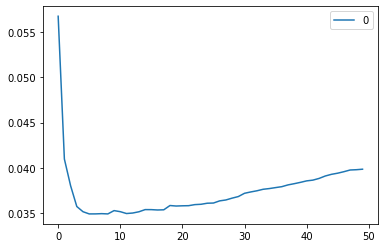

In [17]:
curve = pd.DataFrame(mse_tests) #elbow curve 
curve.plot()

### Candidate Model with selected features

In [18]:


from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import math


rf = RandomForestRegressor(n_estimators = 20,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             
                                                                                           rf.score(X_test, y_test)))

print('Mean Squared Error: {:.2f}'.format(mean_squared_error(y_test, rf_predictions)))

dfg = pd.DataFrame (columns = ['True','predicted'])
dfg['True'] = y_test.values
dfg['predicted'] = list(rf_predictions)
print(dfg.head())

R^2 Training Score: 0.96 
R^2 Validation Score: 0.70
Mean Squared Error: 0.02
   True  predicted
0   4.0       4.00
1   4.5       4.50
2   4.5       4.55
3   4.0       4.00
4   4.0       4.10


### Result Analysis

__The true and predicted values are shown above for the selected candidate model viz. Random Forest.__

### checking the model for overfitting

In [22]:
rf = RandomForestRegressor(n_estimators=1)
mse_trains2 = []
mse_tests2 = []
for iter in range(50):
    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_predicted)
    mse_test = mean_squared_error(y_test, y_test_predicted)
    mse_tests2.append(mse_test)
    print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    rf.n_estimators += 1
    

    

Iteration: 0 Train mse: 0.018876828692779613 Test mse: 0.0492988606485539
Iteration: 1 Train mse: 0.010441245870693724 Test mse: 0.034563978965819454
Iteration: 2 Train mse: 0.007930889832730327 Test mse: 0.02974973220371993
Iteration: 3 Train mse: 0.006415172251061822 Test mse: 0.028360539000876425
Iteration: 4 Train mse: 0.006125530910806976 Test mse: 0.02802804557405785
Iteration: 5 Train mse: 0.005826909968014262 Test mse: 0.026968302658486713
Iteration: 6 Train mse: 0.005236875306989247 Test mse: 0.02659231966230839
Iteration: 7 Train mse: 0.005165319726285984 Test mse: 0.025679913453111308
Iteration: 8 Train mse: 0.004618705538950931 Test mse: 0.02512686510641521
Iteration: 9 Train mse: 0.004753421425200563 Test mse: 0.025008764241893078
Iteration: 10 Train mse: 0.004575875880951181 Test mse: 0.02544346339661454
Iteration: 11 Train mse: 0.0044455587016936715 Test mse: 0.025583674164962513
Iteration: 12 Train mse: 0.004368059065485277 Test mse: 0.02446338465687215
Iteration: 13 Tr

__Based on the data, the Trained Mean Square Error and the Test Mean Square Error seem to be fixed to 0.003 after a certain number of iteration and this shows that the error moves to minimum by the iteration that proves that the model is not overfitting.__



### Learning Curve of Random Forest

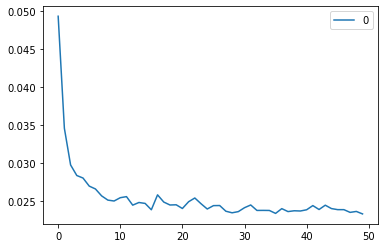

In [23]:
curve = pd.DataFrame(mse_tests2) #elbow curve 
curve.plot()

### References

1. Lecture Slides

2. Lab Tutorials

3. Markdown for Jupyter notebooks cheatsheet. Retrieved from https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed <a id='3'></a>

4. Feature Selection using forward selection wrapper method. Retrieved from https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

5. Mean Squared Error or R-Squared – Which one to use? Retrieved from https://vitalflux.com/mean-square-error-r-squared-which-one-to-use/

6. 3 Best metrics to evaluate Regression Model? Retrieved from https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b